In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 30)

In [3]:
df = pd.read_csv('ver1.csv', index_col=['id'])
display(df.columns)
df.drop(columns=['production_countries', 'production_companies', 'genres', 'release_date', 
                 'popularity_norm', 'year', 'original_language', 'fr', 'ru', 'es', 'hi', 
                 'ja', 'it', 'ko', 'cn', 'zh', 'others', 'month', 'date'], inplace=True)

# col_norm = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count', 'popularity_norm']

df_norm = df

display(df_norm.columns)
display(df_norm)
# df_norm[col_norm] = (df_norm[col_norm] - df_norm[col_norm].mean()) / df_norm[col_norm].std()
df_norm_mean = df_norm.mean()
df_norm_std = df_norm.std()

df_norm = (df_norm - df_norm_mean) / df_norm_std

# display(df_norm[df_norm.isna().any(axis=1)])
display(len(df_norm.columns), len(df_norm))

X_train, X_test = train_test_split(df_norm, test_size = 0.1, random_state=123)

X_train = pd.DataFrame(data=X_train)
y_train = X_train[['revenue']]
X_train = X_train.drop(columns=['revenue'])
X_test = pd.DataFrame(data=X_test)
y_test = X_test[['revenue']]
X_test = X_test.drop(columns=['revenue'])

Index(['budget', 'genres', 'original_language', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'vote_average', 'vote_count', 'popularity_norm',
       'year', 'month', 'date', 'quarter', 'others', 'en', 'fr', 'ru', 'es',
       'hi', 'ja', 'it', 'ko', 'cn', 'zh'],
      dtype='object')

Index(['budget', 'popularity', 'revenue', 'runtime', 'vote_average',
       'vote_count', 'quarter', 'en'],
      dtype='object')

,budget,popularity,revenue,runtime,vote_average,vote_count,quarter,en
id,,,,,,,,
5,4000000,22.876230,4300000,98.0,6.5,530,4,1
11,11000000,126.393695,775398007,121.0,8.1,6624,2,1
12,94000000,85.688789,940335536,100.0,7.6,6122,2,1
13,55000000,138.133331,677945399,142.0,8.2,7927,3,1
14,15000000,80.878605,356296601,122.0,7.9,3313,3,1
...,...,...,...,...,...,...,...,...
365222,36000000,19.167377,156844753,105.0,6.5,379,4,0
375290,4500000,2.551559,32000000,126.0,7.3,57,1,0
376659,20000000,42.512296,183936074,100.0,6.3,1252,3,1


8

3169

In [4]:
# kmeans = KMeans(n_clusters=10)
# cluster_predict = kmeans.fit_predict(X_train)
# display(X_train, cluster_predict)

In [5]:
max_k = 10

In [6]:
pca = PCA(n_components=5)
np_pca = pca.fit_transform(X_train)
print(f'The explained variance is:\n{pca.explained_variance_ratio_}\n')
# display(pca.components_)
# display(np.sort(pca.components_[0])[::-1])
# display(pca.components_[0].argsort()[::-1])
print(f'In 1st PCA axis, the ordering of columns in descending order:\n{X_train.columns[pca.components_[0].argsort()[::-1]]}')

The explained variance is:
[0.35221485 0.18787926 0.14352922 0.11597556 0.11117019]

In 1st PCA axis, the ordering of columns in descending order:
Index(['vote_count', 'popularity', 'budget', 'vote_average', 'runtime',
       'quarter', 'en'],
      dtype='object')


# PCA + KMeans

1. Get PCA with `n_components = 5`
2. Do KMeans Training with `k = 2, 3, ..., 10`
3. (Optional) Do Meta Learning on the KMeans output vs the actual revenue class
4. Plot the scatter graph of KMeans clustering and the result of Binning the Revenue column (the larger/brighter the label, the higher the revenue)
5. Validate the result with test data (`test_split = 0.2`)

array([0.35221485, 0.18787926, 0.14352922, 0.11597556, 0.11117019])

Working on K=2
Working on K=3
Working on K=4
Working on K=5
Working on K=6
Working on K=7
Working on K=8
Working on K=9
Working on K=10


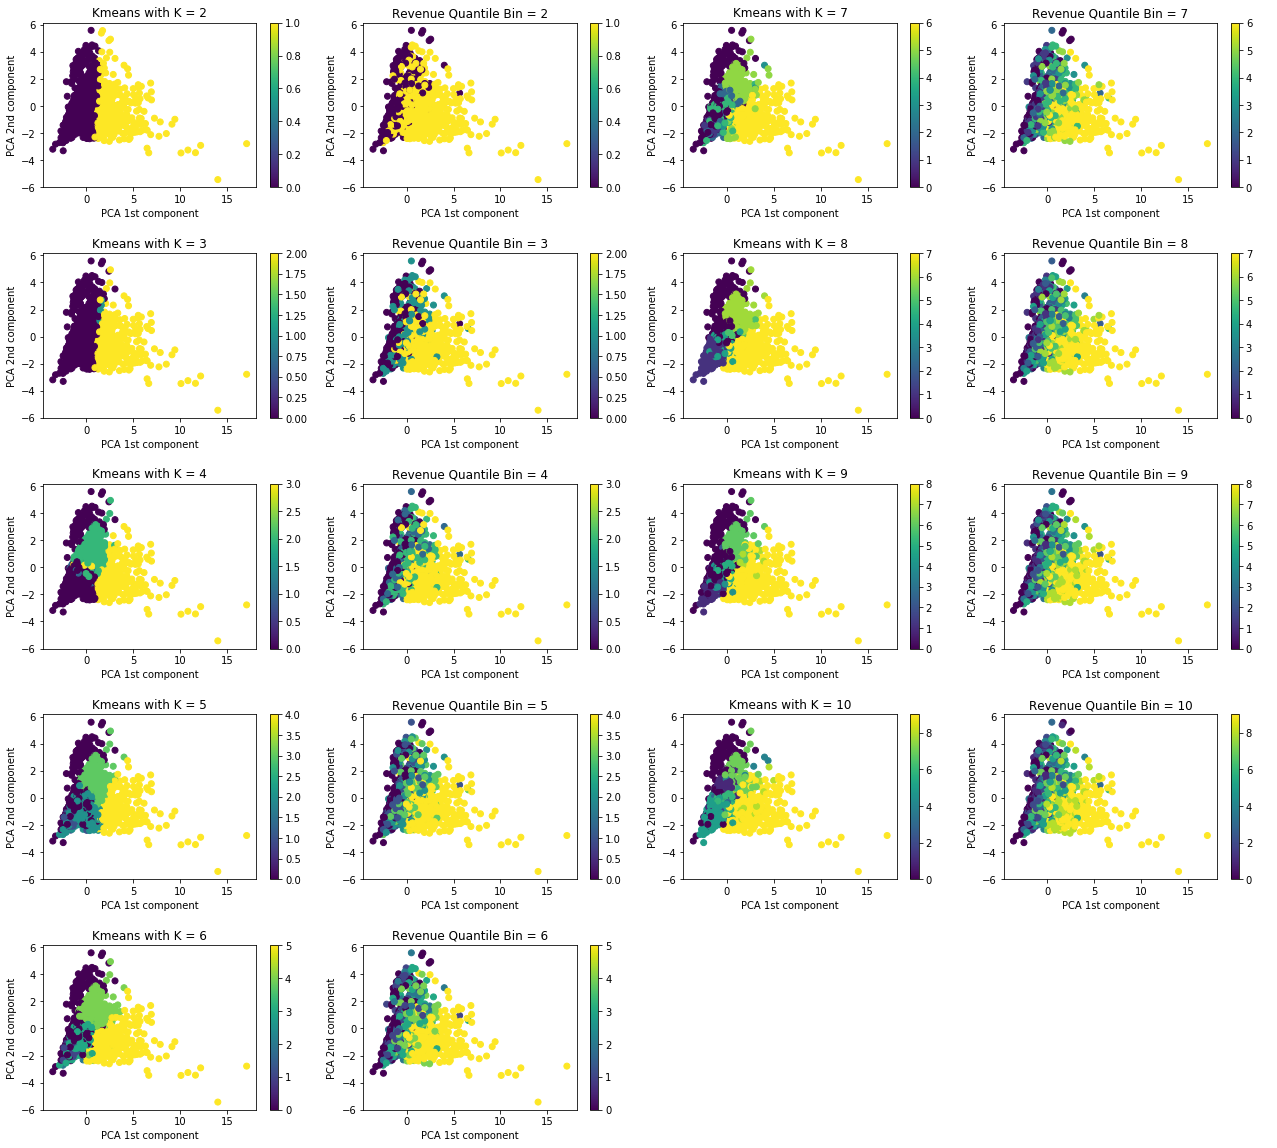

In [11]:
# see the difference with different K with ensemble learning of 200 KMeans model on training data

pca = PCA(n_components=5)
np_pca = pca.fit_transform(X_train)
display(pca.explained_variance_ratio_)
fig, axs = plt.subplots(int(max_k / 2), 4, figsize=(22, 20))
plt.subplots_adjust(hspace=0.4, wspace=0.2)

models_store = {
    'pca': pca,
    'kmeans': [],
    'dt': [],
    'bins': [],
    'ensemble_dt': [],
}

train_data_save = {
    'y_train': [],
    'X_train': [],
}

ensemble_num = 100

for i in range(2, max_k + 1):
# for i in range(2, 3):
    print(f'Working on K={i}')
    kmeans = [KMeans(n_clusters=i, random_state=j) for j in range(ensemble_num)]
    cluster_predict = np.array([kmeans[j].fit_predict(X_train) for j in range(ensemble_num)]).T
    
    models_store['kmeans'].append(kmeans)

    df_pca = pd.DataFrame(data=np_pca[:, :2], columns=['pca_1st_col', 'pca_2nd_col'], index=X_train.index)
    
    df_pca['revenue'] = y_train['revenue']
    _, bins = pd.qcut(df_norm['revenue'], i, retbins=True, labels=[*range(i)])
    ser = pd.cut(y_train['revenue'], bins=bins, labels=[*range(i)], include_lowest=True)
    df_pca['revenue_bin_label'] = ser
    df_pca['cluster'] = cluster_predict.tolist()
    
    models_store['bins'].append(bins)
    
    # predict cluster actual label
    y_true_np = df_pca[['revenue_bin_label']].to_numpy()
    clf = [DecisionTreeClassifier(max_depth=1, random_state=j) for j in range(ensemble_num)]
    clf = [clf[dt].fit(cluster_predict[:, dt].reshape(-1, 1), y_true_np) for dt in range(len(clf))]
    models_store['dt'].append(clf)
    
    cluster_2nd_predict = [clf[dt].predict(cluster_predict[:, dt].reshape(-1, 1)) for dt in range(len(clf))]
    cluster_2nd_predict = np.array(cluster_2nd_predict).T
    
    ensemble_dt = DecisionTreeClassifier(random_state=1)
    ensemble_dt.fit(cluster_2nd_predict, y_true_np)
    models_store['ensemble_dt'].append(ensemble_dt)
    
    df_pca['cluster_pred'] = ensemble_dt.predict(cluster_2nd_predict)
    train_data_save['y_train'].append(y_true_np)
    train_data_save['X_train'].append(cluster_2nd_predict)
    
    axs[int((i-2)%5), int((i-2)/5) * 2].set_ylabel('PCA 2nd component')
    axs[int((i-2)%5), int((i-2)/5) * 2].set_xlabel('PCA 1st component')
    axs[int((i-2)%5), int((i-2)/5) * 2].set_title(f'Kmeans with K = {i}')
    f1 = axs[int((i-2)%5), int((i-2)/5) * 2].scatter(df_pca['pca_1st_col'], df_pca['pca_2nd_col'], c=df_pca['cluster_pred'], cmap='viridis')
    fig.colorbar(f1, ax=axs[int((i-2)%5), int((i-2)/5) * 2])

    axs[int((i-2)%5), int((i-2)/5) * 2 + 1].set_ylabel('PCA 2nd component')
    axs[int((i-2)%5), int((i-2)/5) * 2 + 1].set_xlabel('PCA 1st component')
    axs[int((i-2)%5), int((i-2)/5) * 2 + 1].set_title(f'Revenue Quantile Bin = {i}')
    f2 = axs[int((i-2)%5), int((i-2)/5) * 2 + 1].scatter(df_pca['pca_1st_col'], df_pca['pca_2nd_col'], c=df_pca['revenue_bin_label'], cmap='viridis')
    fig.colorbar(f2, ax=axs[int((i-2)%5), int((i-2)/5) * 2 + 1])
    
axs[4, 2].axis('off')
axs[4, 3].axis('off')
fig.show()

array([0.35221485, 0.18787926, 0.14352922, 0.11597556, 0.11117019])

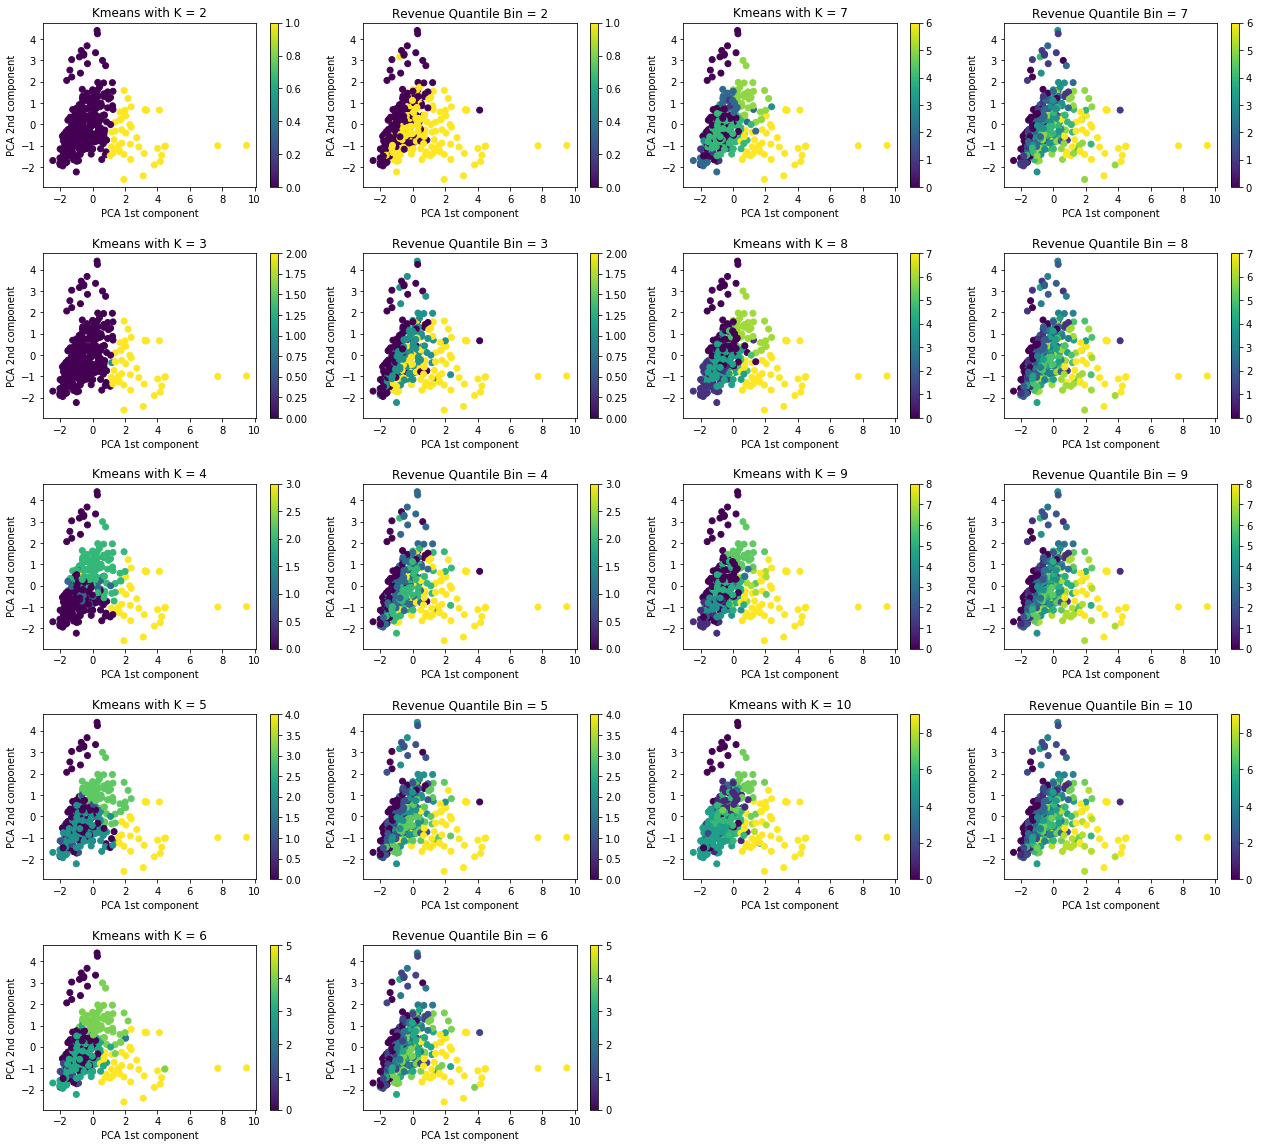

In [13]:
# see the difference with different K with ensemble learning on testing data

pca = models_store['pca']
np_pca = pca.transform(X_test)
display(pca.explained_variance_ratio_)
fig, axs = plt.subplots(int(max_k / 2), 4, figsize=(22, 20))
plt.subplots_adjust(hspace=0.4, wspace=0.2)

test_data_save = {
    'y_pred': [],
    'y_true': [],
    'y_pred_2': [],
}

for i in range(2, max_k + 1):
    kmeans = models_store['kmeans'][i - 2]
    cluster_predict = np.array([clf.predict(X_test) for clf in kmeans]).T
    
    df_pca = pd.DataFrame(data=np_pca[:, :2], columns=['pca_1st_col', 'pca_2nd_col'], index=X_test.index)
    
    df_pca['revenue'] = y_test['revenue']
    bins = models_store['bins'][i - 2]
    ser = pd.cut(y_test['revenue'], bins=bins, labels=[*range(i)], include_lowest=True)

    df_pca['revenue_bin_label'] = ser
    df_pca['cluster'] = cluster_predict.tolist()
    
    test_data_save['y_true'].append(ser)
    test_data_save['y_pred'].append(cluster_predict)

    # predict cluster actual label
    clf = models_store['dt'][i - 2]
    cluster_2nd_predict = np.array([clf[dt].predict(cluster_predict[:, dt].reshape(-1, 1)) for dt in range(len(clf))]).T
    
    ensemble_dt = models_store['ensemble_dt'][i - 2]
    df_pca['cluster_pred'] = ensemble_dt.predict(cluster_2nd_predict)
    test_data_save['y_pred_2'].append(df_pca['cluster_pred'])

    axs[int((i-2)%5), int((i-2)/5) * 2].set_ylabel('PCA 2nd component')
    axs[int((i-2)%5), int((i-2)/5) * 2].set_xlabel('PCA 1st component')
    axs[int((i-2)%5), int((i-2)/5) * 2].set_title(f'Kmeans with K = {i}')
    f1 = axs[int((i-2)%5), int((i-2)/5) * 2].scatter(df_pca['pca_1st_col'], df_pca['pca_2nd_col'], c=df_pca['cluster_pred'], cmap='viridis')
    fig.colorbar(f1, ax=axs[int((i-2)%5), int((i-2)/5) * 2])


    axs[int((i-2)%5), int((i-2)/5) * 2 + 1].set_ylabel('PCA 2nd component')
    axs[int((i-2)%5), int((i-2)/5) * 2 + 1].set_xlabel('PCA 1st component')
    axs[int((i-2)%5), int((i-2)/5) * 2 + 1].set_title(f'Revenue Quantile Bin = {i}')
    f2 = axs[int((i-2)%5), int((i-2)/5) * 2 + 1].scatter(df_pca['pca_1st_col'], df_pca['pca_2nd_col'], c=df_pca['revenue_bin_label'], cmap='viridis')
    fig.colorbar(f2, ax=axs[int((i-2)%5), int((i-2)/5) * 2 + 1])
    
axs[4, 2].axis('off')
axs[4, 3].axis('off')
fig.show()

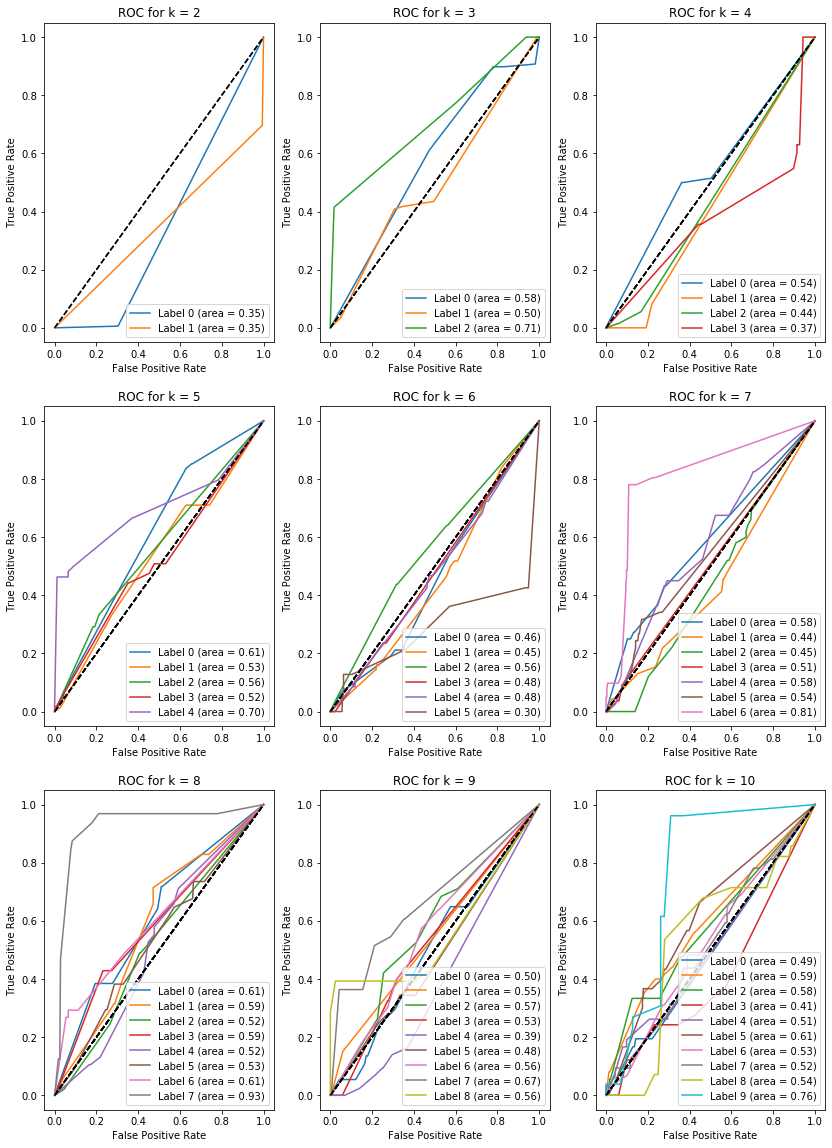

In [8]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(14, 20))

for k in range(2, max_k + 1):
    n_classes = k
    
    y_test_evaluate = np.array(test_data_save['y_true'][k - 2]).reshape(-1, 1)
    y_train_evaluate = np.array(train_data_save['y_train'][k - 2]).reshape(-1, 1)
    y_train_evaluate_len = len(y_train_evaluate)
    y_test_evaluate_len = len(y_test_evaluate)
    X_train_evaluate = np.array(train_data_save['X_train'][k - 2])
    X_test_evaluate = np.array(test_data_save['y_pred'][k - 2])
    
    if k == 2:
        y_test_evaluate = label_binarize(y_test_evaluate, classes=[0, 1, 2])
    else:
        y_test_evaluate = label_binarize(y_test_evaluate, classes=[*range(k)])

    # classifier
    clf = OneVsRestClassifier(estimator=models_store['ensemble_dt'][k - 2])
    y_score_evaluate = clf.fit(X_train_evaluate, y_train_evaluate).predict_proba(X_test_evaluate)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_evaluate[:, i], y_score_evaluate[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot of a ROC curve for a specific class
    for i in range(n_classes):
        axs[int((k - 2) / 3), (k - 2) % 3].plot(fpr[i], tpr[i], label=f'Label {i} (area = {roc_auc[i]:0.2f})')
        axs[int((k - 2) / 3), (k - 2) % 3].plot([0, 1], [0, 1], 'k--')
        axs[int((k - 2) / 3), (k - 2) % 3].axis(xlim=[0.0, 1.0], ylim=[0.0, 1.05])
        axs[int((k - 2) / 3), (k - 2) % 3].set_xlabel('False Positive Rate')
        axs[int((k - 2) / 3), (k - 2) % 3].set_ylabel('True Positive Rate')
        axs[int((k - 2) / 3), (k - 2) % 3].set_title(f'ROC for k = {k}')
        axs[int((k - 2) / 3), (k - 2) % 3].legend(loc="lower right")
fig.show()

In [9]:
# from sklearn.tree import export_graphviz
# from graphviz import Source

# ensemble_dt_10 = models_store['ensemble_dt'][8]

# k_10 = models_store['kmeans'][8][0]
# display(k_10.cluster_centers_)

# dotfile = open("dt_10.dot", 'w')
# dt_10 = models_store['dt'][8]
# high_revenue_cluster_center = k_10.cluster_centers_[9]
# # display(high_revenue_cluster_center)
# # display(df_norm.columns)
# # df_col = df_norm.columns.drop('revenue')
# # df_norm = (df_norm - df_norm_mean) / df_norm_std
# cluster_norm_df = pd.DataFrame(data=[high_revenue_cluster_center], columns=df_norm.columns.drop('revenue'))
# cluster_df = cluster_norm_df * df_norm_std + df_norm_mean
# cluster_df = cluster_df[df_norm.columns.drop('revenue')]
# cluster_df = cluster_df.transpose().round(2)
# cluster_df = cluster_df.rename(columns={0: 'k = 10, label = 9 (max in 0-based index)'})
# with pd.option_context('display.float_format', '{:,.2f}'.format):
#     display(cluster_df)

# # Source(export_graphviz(dt_10, out_file=None, feature_names=['cluster_label'], class_names=[str(x) for x in range(10)]))

# k_10_budget = cluster_df.loc['budget', :][0]
# revenue_np_array = np.array(df['revenue'].reset_index(drop=True))
# revenue_np_array = np.append(revenue_np_array, k_10_budget)
# revenue_np_array_argsort = revenue_np_array.argsort()
# k_10_budget_percentile = revenue_np_array_argsort[-1] / np.max(revenue_np_array_argsort)
# # display(revenue_np_array_argsort[-1], np.max(revenue_np_array_argsort))
# print(f'The percentile of the budget is {round(k_10_budget_percentile, 2)} for budget {k_10_budget:,.2f}')

In [10]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report


y_true = np.array(test_data_save['y_true'][10 - 2]).reshape(-1, 1)
y_pred = np.array(test_data_save['y_pred_2'][10 - 2]).reshape(-1, 1)

display(multilabel_confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

array([[[261,  20],
        [ 31,   5]],

       [[252,  40],
        [ 21,   4]],

       [[278,   3],
        [ 36,   0]],

       [[271,  13],
        [ 33,   0]],

       [[273,   2],
        [ 42,   0]],

       [[204,  83],
        [ 20,  10]],

       [[238,  50],
        [ 22,   7]],

       [[266,  19],
        [ 26,   6]],

       [[285,   4],
        [ 28,   0]],

       [[263,  28],
        [  3,  23]]])

              precision    recall  f1-score   support

           0       0.20      0.14      0.16        36
           1       0.09      0.16      0.12        25
           2       0.00      0.00      0.00        36
           3       0.00      0.00      0.00        33
           4       0.00      0.00      0.00        42
           5       0.11      0.33      0.16        30
           6       0.12      0.24      0.16        29
           7       0.24      0.19      0.21        32
           8       0.00      0.00      0.00        28
           9       0.45      0.88      0.60        26

    accuracy                           0.17       317
   macro avg       0.12      0.19      0.14       317
weighted avg       0.11      0.17      0.13       317



# Insight

1. Using higher K and binning, could be able to predict higher revenue movie
2. Since data is not large enough, by having more data from various classes and backgrounds, the prediction could be more accurate